# Create temperature profile plots for MPAS-O and ROMS

In [ ]:
import xarray as xr
import xroms
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os
import cmocean.cm as cmo
import numpy as np
from numba_celltree import CellTree2d, demo
import time

from glob import glob
import graphviz

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import dask
from dask.distributed import Client

client = Client()
client

In [3]:
# Legend for plots
res_lgd = ['10 km', '5 km', '2 km', '1 km', '500 m', '200 m', '100 m']

In [ ]:
# Create consistent rainbow-like colormap for different model resolutions
rainbow_cmap = np.asarray([[165,0,38],
                         [215,48,39],
                         [253,174,97],
                         [0,0,0],
                         [171,217,233],
                         [116,173,209],
                         [49,54,149]]) / 255


## Load MPAS-O model outputs

In [6]:
mroots = [
         '/mpaso_channel/10km/',
         '/mpaso_channel/5km/',
         '/mpaso_channel/2km/',
         '/mpaso_channel/1km/',
         '/mpaso_channel/500m/',    
         '/mpaso_channel/200m/',
         '/mpaso_channel/100m/'
]

In [ ]:
mds = []
mdsg = []
midx = []

for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    mds.append(ds_mpas)
    mdsg.append(dsg)

    verts = np.dstack((dsg.xVertex.values[dsg.verticesOnCell-1],
                       dsg.yVertex.values[dsg.verticesOnCell-1]))
    nverts = np.sum(dsg.verticesOnCell != 0, axis=1).values
    verts = [vert[:n] for vert, n in zip(verts, nverts)]
    idx = [(np.abs(vert[:, 0].ptp()) < 50000) for vert in verts]
    midx.append(idx)


In [ ]:
# Calculate along-channel temperature averages by depth level

mzvals = []
mpas_tavg = []
mpas_ini = []

for midx in range(len(mroots)):
    ympas = mdsg[midx].yCell.values
    # Only grab temperature data from y=50 to y=250 km (away from walls of domain)
    idx = np.where(np.logical_and(ympas>50000, ympas<250000))
    # Calculate average temperature over 5-day period of maximum KE
    mpas_temp = mds[midx].temperature.isel(
                Time=slice(132, 192),
                nCells=slice(idx[0][0], idx[0][-1])).mean(
                dim=['Time', 'nCells'], dtype=np.float64)).compute()
    # Grab temperature profile at initial time step                
    ini_avg = mds[midx].temperature.isel(
                Time=0,
                nCells=slice(idx[0][0], idx[0][-1])).mean(
                dim=['nCells'], dtype=np.float64).compute()
    
    mpas_tavg.append(mpas_temp)
    mpas_ini.append(ini_avg)
    mzvals.append(mdsg[midx].refZMid.values) # save depth values


(-2.0, 2.5)

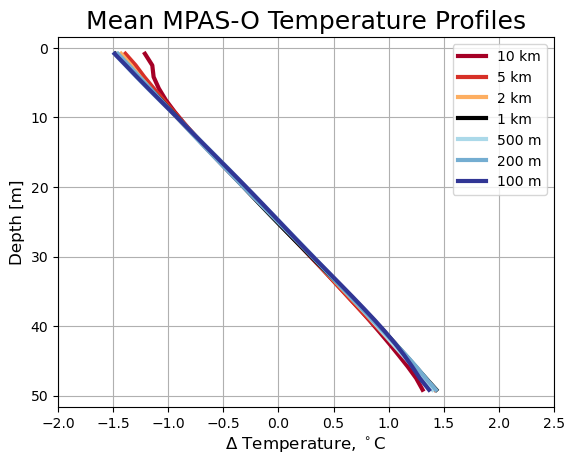

In [6]:
# Plot just the MPAS-O average temperature profiles
fig = plt.figure()
ax = fig.add_subplot(111)

ictr = 0
for axi in range(len(mroots)):
    plt.plot(mpas_tavg[axi]-mpas_ini[axi], abs(mzvals[axi]),
             linewidth=3, color=rainbow_cmap[ictr])
    ictr+=1

ax.grid(True)
ax.set_xlabel('$\Delta$ Temperature, $^\circ$C', fontsize=12)
ax.set_ylabel('Depth [m]', fontsize=12)
ax.legend(res_lgd, loc='best')
ax.set_title('Mean MPAS-O Temperature Profiles', fontsize=18, loc='center')
plt.gca().invert_yaxis()
plt.xlim((-2, 2.5))

## Load ROMS model outputs

In [11]:
roms_files = [
         '/roms_channel/10km/roms_his.nc',
         '/roms_channel/5km/roms_his.nc',
         '/roms_channel/2km/roms_his.nc',
         '/roms_channel/1km/roms_his.nc',
         '/roms_channel/500m/roms_his.nc',
         '/roms_channel/200m/roms_his.nc',
         '/roms_channel/100m/roms_his.nc',
        ]


In [ ]:
rdss = []
for file in rfiles:
    ds = xr.open_dataset(file, chunks={'ocean_time': 1})
    ds, xgrid = xroms.roms_dataset(ds) # run this to calculate depth values
    rdss.append(ds)

In [ ]:
roms_tavg = []
roms_ini = []
rzvals = []

for ds in rdss:
    conditional = (ds.y_rho > 50e3) & (ds.y_rho < 250e3)
    grab_temp = ds.temp.where(conditional)
    # Calculate average temperature over 5-day period of maximum KE
    temp_avg = grab_temp.isel(
                ocean_time=slice(96,156)).mean(
                dim=["ocean_time","xi_rho","eta_rho"], skipna=True).values
    # Grab temperature profile at initial time step
    temp_iniavg = grab_temp.isel(ocean_time=0).mean(
                dim=["xi_rho","eta_rho"], skipna=True).values
    
    roms_tavg.append(temp_avg)
    roms_ini.append(temp_iniavg)
    # Get ROMS depth values for plot
    dzplot = ds.z_rho.isel(ocean_time=0).mean(dim=["eta_rho", "xi_rho"]).values
    rzvals.append(dzplot)    


## Make combined plot of temperature profiles for both MPAS-O and ROMS

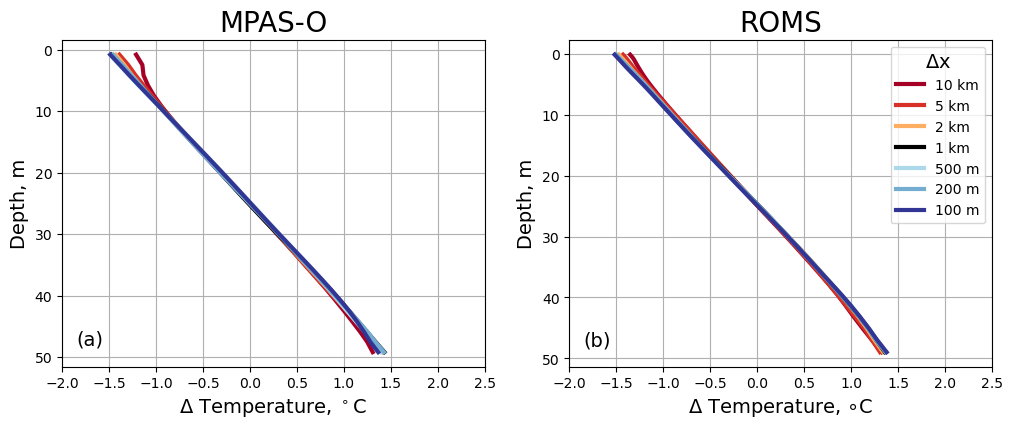

In [18]:
# Plot average MPAS-O and ROMS temperature profiles
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4.25))

ax=ax0 # MPAS-O temperature profiles
ictr = 0
for axi in range(len(mroots)):
    ax.plot(mpas_tavg[axi]-mpas_ini[axi], abs(mzvals[axi]),
             linewidth=3, color=rainbow_cmap[ictr])
    ictr+=1

ax.grid(True)
ax.set_xlabel('$\Delta$ Temperature, $^\circ$C', fontsize=14)
ax.set_ylabel('Depth, m', fontsize=14)
ax.set_title('MPAS-O', fontsize=20, loc='center')
ax.invert_yaxis()
ax.set_xlim((-2, 2.5))
ax.text(-1.85, 48, '(a)', fontsize=14)


ax=ax1 # ROMS temperature profiles
ictr=0
for axi in range(len(rdss)):    
    ax.plot(roms_tavg[axi]-roms_ini[axi], abs(rzvals[axi]),
             linewidth=3, color=rainbow_cmap[ictr])
    ictr+=1

ax.grid(True)
ax.set_xlabel('$\Delta$ Temperature, $\circ$C', fontsize=14)
ax.set_ylabel('Depth, m', fontsize=14)
l1 = ax.legend(res_lgd, loc='best', title='$\Delta$x')
l1.get_title().set_fontsize('14')
ax.set_title('ROMS', fontsize=20, loc='center')
ax.invert_yaxis()
ax.set_xlim(-2, 2.5)
ax.text(-1.85, 48, '(b)', fontsize=14)
